# Getting data of an election

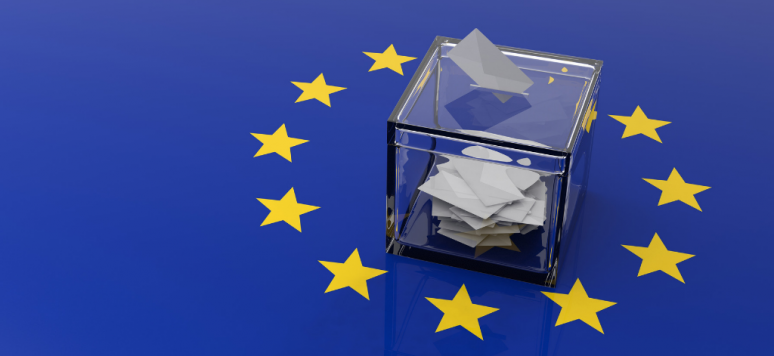

On the 26th of May, we had the european parliamentary elections. In Romania, the results and progress of the vote were published online in real time on the [official electoral site](https://prezenta.bec.ro/europarlamentare26052019).

As far as I know it's the first time we had such data exposed to the public, and with such granularity. 

Since my daily work involves working closely with data, I couldn't miss the oportunity to get my hands on that dataset. Of course, the site is not documented and there aren't any publicly available API's to begin with. So I spent some hours debugging the underlying stack to see how I can query it and compile it in a usable format.

As far as I see it's built with React, using some NoSQL as the backend. I'm betting on NoSQL because, while doing the ETL I've found some schema inconsistencies that shouldn't normally happen if the data sat on top of a SQL DB.

# Understanding the API

Maybe there's better way to do this, but what I did was start the developer console of the browser, refresh the election page and look for a request that seemed to contain the data that I was looking for. Using this approach I've found the following endopoints that I could query.

An example of how you interogate the BEC site, for the `presence` data. You need to know the `county` (in this case AR, code for ARAD).

In [1]:
!curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/json//pv_AR.json' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' --compressed -o "_data/AR.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73871    0 73871    0     0   319k      0 --:--:-- --:--:-- --:--:--  319k


There is also an endpoint publishing the `presence` count (the number of people that voted so far ). Again, we also need to query this for each `county`.

In [112]:
!curl 'https://prezenta.bec.ro/europarlamentare26052019/data/presence/json/presence_AR_now.json?_=1561376443437' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-precincts' -H 'authority: prezenta.bec.ro' -H 'cookie: _ga=GA1.2.772980748.1558943895; _gid=GA1.2.1466959792.1561374632; _gat=1' --compressed -o "_data/AR-presence.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60786    0 60786    0     0   690k      0 --:--:-- --:--:-- --:--:--  690k


There is also another csv that we can use, which contains the `presence` data in a single big file.

In [ ]:
!curl 'https://prezenta.bec.ro/europarlamentare26052019/data/presence/csv/presence_now.csv' -H 'Referer: https://prezenta.bec.ro/europarlamentare26052019/abroad-pv-part' --compressed -o "_data/all_presence.csv"

# Fetching the data

Getting all the data ouf of the site. Each county has a dedicated page which contains information about its stats. By looking over the source of the site we can compile a list of all counties that we need to inspect. It's instersting that the S1..S6 (Bucharest's sectors) were modeled as counties. 

In [193]:
counties = ["AR", "AB", "AR", "AG", "BC", "BH", "BN", "BT", "BV", "BR", "BZ", "CS", "CL", "CJ", "CT", "CV", "DB", "DJ", "GL", "GR", "GJ", "HR", "HD", "IL", "IS", "IF", "MM", "MH", "MS", "NT", "OT", "PH", "SM", "SJ", "SB", "SV", "TR", "TM", "TL", "VS", "VL", "VN", "B", "SR", "S1", "S2", "S3", "S4", "S5", "S6"]
len(counties)

50

The `vote` information is stored on the `data/pv/json/` route, specific for each county. In order not to make multiple queries while testing, we first cache all the results localy and we can refer to them later on.

Above we've deduced the counties we can have, but I've found that there are slight asymetries for certain cases (mostly regarding the expat data and the way Bucharest is represented).

It's because of this that we need to handle the counties list in a case-by-case fashion.

In [6]:
import json
from tqdm import tqdm_notebook as tqdm

In [5]:
counties = ["AR", "AB", "AR", "AG", "BC", "BH", "BN", "BT", "BV", "BR", "BZ", "CS", "CL", "CJ", "CT", "CV", "DB", "DJ", "GL", "GR", "GJ", "HR", "HD", "IL", "IS", "IF", "MM", "MH", "MS", "NT", "OT", "PH", "SM", "SJ", "SB", "SV", "TR", "TM", "TL", "VS", "VL", "VN", "S1", "S2", "S3", "S4", "S5", "S6"]
for county in tqdm(counties):
    !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/json//pv_{county}.json' -H 'accept-encoding: gzip, deflate, br'  -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' --compressed -o "_data/{county}.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73925    0 73925    0     0   322k      0 --:--:-- --:--:-- --:--:--  323k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69866    0 69866    0     0   710k      0 --:--:-- --:--:-- --:--:--  710k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73925    0 73925    0     0   707k      0 --:--:-- --:--:-- --:--:--  707k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81264    0 81264    0     0   583k      0 --:--:-- --:--:-- --:--:--  583k
  % Total    % Received % Xferd  Average Speed   Tim

100 60674    0 60674    0     0   502k      0 --:--:-- --:--:-- --:--:--  502k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83476    0 83476    0     0   783k      0 --:--:-- --:--:-- --:--:--  783k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 53441    0 53441    0     0   573k      0 --:--:-- --:--:-- --:--:--  573k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88150    0 88150    0     0   789k      0 --:--:-- --:--:-- --:--:--  782k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41482    0 41482    0     0   440k      0 --:--:

The `presence` data is (as above) stored in a different (`data/presence/json/`) route specific to each county. Again, we fetch everything an cache localy.

In [196]:
counties = ["AR", "AB", "AR", "AG", "BC", "BH", "BN", "BT", "BV", "BR", "BZ", "CS", "CL", "CJ", "CT", "CV", "DB", "DJ", "GL", "GR", "GJ", "HR", "HD", "IL", "IS", "IF", "MM", "MH", "MS", "NT", "OT", "PH", "SM", "SJ", "SB", "SV", "TR", "TM", "TL", "VS", "VL", "VN", "B", "SR"]
for county in tqdm(counties[-8:-6]):
    !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/presence/json/presence_{county}_now.json' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-precincts' -H 'authority: prezenta.bec.ro' --compressed -o "_data/{county}-presence.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92928    0 92928    0     0   810k      0 --:--:-- --:--:-- --:--:--  810k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41312    0 41312    0     0   458k      0 --:--:-- --:--:-- --:--:--  458k


Let's also get the `all in one` data about the `presence`.

In [215]:
!curl 'https://prezenta.bec.ro/europarlamentare26052019/data/presence/csv/presence_now.csv' -H 'Referer: https://prezenta.bec.ro/europarlamentare26052019/abroad-pv-part' --compressed -o "_data/all_presence.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2618k    0 2618k    0     0  5729k      0 --:--:-- --:--:-- --:--:-- 5729k


# Compiling the data

## Loading a `presence` file

When reading the `presence` file, there's some manipulation that we need to do because the original returned json contains lots of information that seemed either useless or redundant (info we already had in other places), or information that I didn't know how to interpret. 

There was also the `age_ranges` field which was contained actually a list of values, that I needed to exapend into individual columns, by using a transform function.

In [175]:
def process_row(row):
    return tuple(row.age_ranges.values())

def load_presence(presence_file_name):
    _json = read_json_file(presence_file_name)
    _df = pd.DataFrame.from_records(_json['precinct'])
    _df[["men_18_24", "men_25_34", "men_35_44", "men_45_64", "men_65+", "women_18_24", "women_25_34", "women_35_44", "women_45_64", "women_65+"]] = _df.apply(process_row, axis=1, result_type='expand')
    _df.drop(columns=['age_ranges'], inplace=True)
    _df.columns = [
        'liste_permanente', 
        'lista_suplimentare', 
        'total', 
        'urna_mobila', 
        'county_code',
        'county_name',
        'id_county',
        'id_locality',
        'id_precinct',
        'id_uat',
        'initial_count',
        'latitude',
        'locality_name',
        'longitude',
        'medium',
        'precinct_name',
        'precinct_nr',
        'presence',
        'siruta',
        'uat_code',
        'uat_name',
        'men_18_24',
        'men_25_34',
        'men_35_44',
        'men_45_64',
        'men_65+',
        'women_18_24',
        'women_25_34',
        'women_35_44',
        'women_45_64',
        'women_65+',
    ]
    return _df

tulcea = load_presence("_data/TL-presence.json")
tulcea.head()

,liste_permanente,lista_suplimentare,total,urna_mobila,county_code,county_name,id_county,id_locality,id_precinct,id_uat,...,men_18_24,men_25_34,men_35_44,men_45_64,men_65+,women_18_24,women_25_34,women_35_44,women_45_64,women_65+
0,409,31,440,0,TL,TULCEA,38,8884,15848,2882,...,13,23,36,84,29,17,22,55,110,51
1,471,73,544,0,TL,TULCEA,38,8884,15849,2882,...,11,28,55,90,71,10,40,62,92,85
2,14,20,34,0,TL,TULCEA,38,8909,15943,2892,...,1,1,5,10,4,0,2,4,5,2
3,134,35,169,0,TL,TULCEA,38,8914,15948,2894,...,5,6,17,37,21,4,9,7,37,26
4,638,70,708,0,TL,TULCEA,38,8912,15946,2894,...,19,42,46,185,78,17,42,53,142,84


## Getting all the individual `result` files for all `precint_nr`

The voting results (what voted for what, in which place) are stored in the `data/pv` route. The problem is that if we only use the `county` file, downloaded in step 3, there isn't any keys that will link the results to the presence rows. To be more exact, the results are listed per voting facilty, whereas the presence is aggregated at a locality level. This means that we can't really jon the two.

Fortuantely, I've found that if you know the id of a specific voting facilty, you could ask for the resuls of that specific facility through a version of the original `results` API.

So the final strategy that worked was something along the following lines:

* For all `countyes`, we will load the `presence` file associated to it
* inspect all the `precint_nr` that is contains
* individually query the api for the results of that `precint_nr`. 

In [213]:
counties = ["AR", "AB", "AR", "AG", "BC", "BH", "BN", "BT", "BV", "BR", "BZ", "CS", "CL", "CJ", "CT", "CV", "DB", "DJ", "GL", "GR", "GJ", "HR", "HD", "IL", "IS", "IF", "MM", "MH", "MS", "NT", "OT", "PH", "SM", "SJ", "SB", "SV", "TR", "TM", "TL", "VS", "VL", "VN", "SR"]
for county in tqdm(counties):
    df_county = load_presence(f"_data/{county}-presence.json")
    for precinct_nr in tqdm(df_county['precinct_nr'].values, leave=False):
        file_name = f"_data/{county}_results_{precinct_nr}.json"
        if not os.path.exists(file_name): 
            !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/csv/pv_{county}_{precinct_nr}_EUP_PART.csv' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' -H 'cookie: _ga=GA1.2.772980748.1558943895; _gid=GA1.2.1466959792.1561374632' --compressed --silent -o "_data/{county}_results_{precinct_nr}.json"
        else:
            with open(file_name) as f:
                file_contents = f.read()
            if "Cod birou electoral" not in file_contents:
                print(f"File: {file_name} has bad content {file_contents[:50]}. Will retry")
                os.remove(file_name)
                !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/csv/pv_{county}_{precinct_nr}_EUP_PART.csv' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' -H 'cookie: _ga=GA1.2.772980748.1558943895; _gid=GA1.2.1466959792.1561374632' --compressed --silent -o "_data/{county}_results_{precinct_nr}.json"

Bucharest is a special case. It's treated as a county but the results are stored by sectors so we need to do things a bit different.

In [210]:
county = "B"
df_county = load_presence(f"_data/{county}-presence.json")
for id_sector in tqdm(df_county.id_locality.unique()):
    sector = f"S{int(id_sector) - 9910 + 1}"
    print(f"Processing: {sector}")
    county = sector
    for precinct_nr in tqdm(df_county[df_county.id_locality == id_sector]['precinct_nr'].values, leave=False):
        file_name = f"_data/{county}_results_{precinct_nr}.json"
        if not os.path.exists(file_name): 
            !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/csv/pv_{county}_{precinct_nr}_EUP_PART.csv' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' -H 'cookie: _ga=GA1.2.772980748.1558943895; _gid=GA1.2.1466959792.1561374632' --compressed --silent -o "_data/{county}_results_{precinct_nr}.json"
        else:
            with open(file_name) as f:
                file_contents = f.read()
            if "Cod birou electoral" not in file_contents:
                print(f"File: {file_name} has bad content {file_contents[:50]}. Will retry")
                os.remove(file_name)
                !curl 'https://prezenta.bec.ro/europarlamentare26052019/data/pv/csv/pv_{county}_{precinct_nr}_EUP_PART.csv' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-GB,en-US;q=0.9,en;q=0.8' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36' -H 'accept: */*' -H 'referer: https://prezenta.bec.ro/europarlamentare26052019/romania-pv-part' -H 'authority: prezenta.bec.ro' -H 'cookie: _ga=GA1.2.772980748.1558943895; _gid=GA1.2.1466959792.1561374632' --compressed --silent -o "_data/{county}_results_{precinct_nr}.json"

Processing: S1


Processing: S5


Processing: S6


Processing: S2


Processing: S3


Processing: S4


In `SR` we have data about the foreign offices.

In [212]:
load_presence("_data/SR-presence.json").head().T

,0,1,2,3,4
liste_permanente,0,0,0,0,0
lista_suplimentare,18,57,865,79,1330
total,18,57,865,79,1330
urna_mobila,0,0,0,0,0
county_code,SR,SR,SR,SR,SR
county_name,STRAINATATE,STRAINATATE,STRAINATATE,STRAINATATE,STRAINATATE
id_county,43,43,43,43,43
id_locality,10244,10178,10334,10206,9996
id_precinct,18619,18627,19096,18716,18723
id_uat,3230,3218,3245,3219,3186


## Reading all the presence data into a single `DataFrame`

We now have all the `presence` data cached, and we'll read it into a single dataframe.

In [262]:
counties = ["AR", "AB", "AR", "AG", "BC", "BH", "BN", "BT", "BV", "BR", "BZ", "CS", "CL", "CJ", "CT", "CV", "DB", "DJ", "GL", "GR", "GJ", "HR", "HD", "IL", "IS", "IF", "MM", "MH", "MS", "NT", "OT", "PH", "SM", "SJ", "SB", "SV", "TR", "TM", "TL", "VS", "VL", "VN", "SR", "B"]
 
df_precints = pd.concat((load_presence(f) for f in tqdm(glob("_data/*-presence.json"))), ignore_index=True)
df_precints.shape

(19171, 31)

In [263]:
df_precints.head().T

,0,1,2,3,4
liste_permanente,696,140,501,571,680
lista_suplimentare,63,10,25,41,55
total,759,150,526,612,736
urna_mobila,0,0,0,0,1
county_code,VS,VS,VS,VS,VS
county_name,VASLUI,VASLUI,VASLUI,VASLUI,VASLUI
id_county,39,39,39,39,39
id_locality,9015,9015,9006,9006,9006
id_precinct,16128,16187,16086,16087,16088
id_uat,2936,2936,2933,2933,2933


The `all_presence.csv` file contains information about age groups, more granular than the bucketed info found in the county files. We will merge it with the current dataframe.

In [222]:
_all_df = pd.read_csv("_data/all_presence.csv")

In [238]:
_all_df.head().T

,0,1,2,3,4
Judet,AB,AB,AB,AB,AB
UAT,MUNICIPIUL ALBA IULIA,MUNICIPIUL ALBA IULIA,MUNICIPIUL SEBEŞ,MUNICIPIUL SEBEŞ,MUNICIPIUL SEBEŞ
Localitate,ALBA IULIA,ALBA IULIA,SEBEŞ,SEBEŞ,SEBEŞ
Siruta,1026,1026,1883,1883,1883
Nr sectie de votare,1,10,100,101,102
Nume sectie de votare,CENTRUL DE ZI PENTRU PERSOANE VÂRSTNICE,COLEGIUL NAŢIONAL „HOREA CLOŞCA ŞI CRIŞAN”,ŞCOALA GIMNAZIALĂ NR. 2 SEBEŞ,COLEGIUL NAŢIONAL ”LUCIAN BLAGA” SEBEŞ,COLEGIUL NAŢIONAL ”LUCIAN BLAGA” SEBEŞ
Mediu,U,U,U,U,U
Votanti lista,1612,1443,1415,1303,1362
LP,901,648,769,697,765
LS,45,143,66,73,27


It's interesting that this file contains presence data on a per year-of-birth grouping (which is more granular than the 10 years buckets we had prior).

## Reading all the results data into a single dataframe.

The individual results files we've got from two steps above, we will load them into a single big pandas `DataFrame`

In [304]:
df_results = pd.concat((pd.read_csv(f) for f in tqdm(glob("_data/*_results_*"))), ignore_index=True)
df_results.shape

(19171, 36)

In [265]:
df_results.head().T

,0,1,2,3,4
Cod birou electoral,22,5,35,35,6
Județ,HUNEDOARA,BIHOR,SUCEAVA,SUCEAVA,BISTRIŢA-NĂSĂUD
Uat,ORAŞ CĂLAN,CEICA,VICOVU DE JOS,MUNICIPIUL SUCEAVA,BUDEŞTI
Localitate,CĂLAN,BUCIUM,VICOVU DE JOS,SUCEAVA,BUDEŞTI-FÂNAŢE
Secție,ŞCOALA GIMNAZIALĂ,ȘCOALA BUCIUM,SCOALA CU CLASELE I-VIII IOAN VICOVEANU,GRĂDINIŢA CU PROGRAM NORMAL NR.7,ŞCOALA PRIMARĂ BUDEŞTI-FÎNAŢE
Nr,190,320,532,61,97
Tip,Europarlamentare,Europarlamentare,Europarlamentare,Europarlamentare,Europarlamentare
a,1471,172,1344,1393,256
a1,1471,172,1344,1393,256
a2,0,0,0,0,0


# Joining the results with the presence data

Some code cleanup are neede. In order to join the two dataframes we need to make slight conversions to make all the keys from both side match.

In [319]:
df_results.loc[df_results.Județ == "STRĂINĂTATE", "Județ"] = "STRAINATATE"
df_results.loc[df_results.Uat == "OMAN", "Uat"] = "SULTANATUL OMAN"
df_results.loc[df_results.Județ == "SECTOR 1", "Județ"] = "MUNICIPIUL BUCUREŞTI"
df_results.loc[df_results.Județ == "SECTOR 2", "Județ"] = "MUNICIPIUL BUCUREŞTI"
df_results.loc[df_results.Județ == "SECTOR 3", "Județ"] = "MUNICIPIUL BUCUREŞTI"
df_results.loc[df_results.Județ == "SECTOR 4", "Județ"] = "MUNICIPIUL BUCUREŞTI"
df_results.loc[df_results.Județ == "SECTOR 5", "Județ"] = "MUNICIPIUL BUCUREŞTI"
df_results.loc[df_results.Județ == "SECTOR 6", "Județ"] = "MUNICIPIUL BUCUREŞTI"

Now, if we merge the two we will get a single big dataframe with the same number of rows but double the columns.

In [322]:
df_precint_with_results = pd.merge(left=df_precints, right=df_results, left_on=["county_name", "uat_name", "precinct_nr"], right_on=["Județ", "Uat", "Nr"])
df_precint_with_results.shape

(19171, 67)

Let's print one example of how one entry this looks like in practice.

In [326]:
dict(df_precint_with_results.iloc[0])

{'liste_permanente': 696,
 'lista_suplimentare': 63,
 'total': 759,
 'urna_mobila': 0,
 'county_code': 'VS',
 'county_name': 'VASLUI',
 'id_county': '39',
 'id_locality': '9015',
 'id_precinct': '16128',
 'id_uat': '2936',
 'initial_count': 1470,
 'latitude': '46.6389853639550',
 'locality_name': 'VASLUI',
 'longitude': '27.7326775437114',
 'medium': 'U',
 'precinct_name': 'CASA DE CULTURĂ A SINDICATELOR ”CONSTANTIN TĂNASE”',
 'precinct_nr': 1,
 'presence': 51.6327,
 'siruta': '161954',
 'uat_code': None,
 'uat_name': 'MUNICIPIUL VASLUI',
 'men_18_24': 13,
 'men_25_34': 31,
 'men_35_44': 66,
 'men_45_64': 110,
 'men_65+': 115,
 'women_18_24': 22,
 'women_25_34': 34,
 'women_35_44': 78,
 'women_45_64': 171,
 'women_65+': 119,
 'Cod birou electoral': 39,
 'Județ': 'VASLUI',
 'Uat': 'MUNICIPIUL VASLUI',
 'Localitate': 'VASLUI',
 'Secție': 'CASA DE CULTURĂ A SINDICATELOR ”CONSTANTIN TĂNASE”',
 'Nr': 1,
 'Tip': 'Europarlamentare',
 'a': 1470,
 'a1': 1470,
 'a2': 0,
 'b': 759,
 'b1': 695,
 '

We will also join the data with the `all_presence.csv` file.

In [425]:
df_full = pd.merge(left=df_precint_with_results, right=_all_df, left_on=["county_code", "uat_name", "precinct_nr"], right_on=["Judet", "UAT", "Nr sectie de votare"])
df_full.shape

(19171, 295)

## Applying the legend

Some of the columns in the above dataframe are not quite obvious (`g1`, .., `g16`, etc..). These are party names that I was only able to find in a legend in the dropdown of a button in the UI of the site. I've copied it here, along with explanations of some fields that I've been able to figure out by looking over the PDF's of official scanned documents.

We also need to convert these column names into more meaningfull lables.

In [426]:
df_full.rename(columns={
    "g1": "PSD",
    "g2": "USR-PLUS",
    "g3": "PRO Romania",
    "g4": "UDMR",
    "g5": "PNL",
    "g6": "ALDE",
    "g7": "PRODEMO",
    "g8": "PMP",
    "g9": "Partidul Socialist Roman",
    "g10": "Partidul Social Democrat Independent",
    "g11": "Partidul Romania Unita",
    "g12": "Uniunea Nationala Pentur Progresul Romaniei",
    "g13": "Blocul Unitatii Nationale",
    "g14": "Gregoriana-Carmen Tudoran",
    "g15": "George-Nicaolae Simion",
    "g16": "Peter Costea",
    "a": "Total alegatori",
    "a1": "Total lista permanenta",
    "a2": "Total urna mobila",
    "b": "Total prezenti",
    "b1": "Prezenti lista permanenta",
    "b2": "Prezenti urna mobila",
    "b3": "Prezenti lista suplimentara",
    "c": "Total voturi",
    "d": "Voturi nefolosite",
    "e": "Voturi valabile",
    "f": "Voturi anulate",
    "h": "Contestatii",
    "i": "Starea sigiliilor"
}, inplace=True)

Ok, let's check for the amount of missing data

In [427]:
na_series = df_full.isna().sum()
na_series[na_series != 0]

latitude               479
longitude              479
siruta                 441
uat_code             18730
Contestatii             19
Starea sigiliilor        8
Siruta                 441
dtype: int64

## Removing duplicate columns

Because we've basically merged two types of `presence` datasets (the `per-county` one and the `all_presence.csv` one) we ended up with some duplicate columns in the joined dataframe. We also have as duplicates the `join on` columns, and columns that contained the same type of information.  

We want to eliminate those. We will find the duplicated columns by:
* using the `pandas.duplicated` method (used on the transposed matix - duplicated only works on rows)
* looking at the correlation matrix of the resulting columns and get the pairs of columns that have the highes correlation.

In [448]:
duplicate_columns = df_full.columns[df_full.T.duplicated(keep=False)]
duplicate_columns

Index(['liste_permanente', 'lista_suplimentare', 'total', 'urna_mobila',
       'county_code', 'county_name', 'initial_count', 'locality_name',
       'medium', 'precinct_name', 'precinct_nr', 'uat_name', 'men_18_24',
       'men_25_34', 'men_35_44', 'men_45_64', 'men_65+', 'women_18_24',
       'women_25_34', 'women_35_44', 'women_45_64', 'women_65+', 'Județ',
       'Uat', 'Nr', 'Judet', 'UAT', 'Localitate_y', 'Nr sectie de votare',
       'Nume sectie de votare', 'Mediu', 'Votanti lista', 'LP', 'LS', 'UM',
       'LT', 'Barbati 18-24', 'Barbati 25-34', 'Barbati 35-44',
       'Barbati 45-64', 'Barbati 65+', 'Femei 18-24', 'Femei 25-34',
       'Femei 35-44', 'Femei 45-64', 'Femei 65+', 'Barbati 104', 'Barbati 106',
       'Barbati 108', 'Barbati 109', 'Barbati 110', 'Barbati 112',
       'Barbati 113', 'Barbati 114', 'Barbati 115', 'Barbati 116',
       'Barbati 117', 'Barbati 118', 'Barbati 119', 'Barbati 120', 'Femei 105',
       'Femei 106', 'Femei 107', 'Femei 108', 'Femei 110',

With these, we will compare each with each and see what searies are equals. This will results in a long list of pairs of columns that are duplicates of one another.

In [465]:
_pairs = set()
for i, _a in enumerate(duplicate_columns):
    for _b in duplicate_columns[i+1:]:
        if (df_full[_a] == df_full[_b]).all():
            _pairs.add(tuple(sorted([_a, _b])))
_pairs

{('Barbati 104', 'Barbati 106'),
 ('Barbati 104', 'Barbati 108'),
 ('Barbati 104', 'Barbati 109'),
 ('Barbati 104', 'Barbati 110'),
 ('Barbati 104', 'Barbati 112'),
 ('Barbati 104', 'Barbati 113'),
 ('Barbati 104', 'Barbati 114'),
 ('Barbati 104', 'Barbati 115'),
 ('Barbati 104', 'Barbati 116'),
 ('Barbati 104', 'Barbati 117'),
 ('Barbati 104', 'Barbati 118'),
 ('Barbati 104', 'Barbati 119'),
 ('Barbati 104', 'Barbati 120'),
 ('Barbati 104', 'Femei 105'),
 ('Barbati 104', 'Femei 106'),
 ('Barbati 104', 'Femei 107'),
 ('Barbati 104', 'Femei 108'),
 ('Barbati 104', 'Femei 110'),
 ('Barbati 104', 'Femei 111'),
 ('Barbati 104', 'Femei 112'),
 ('Barbati 104', 'Femei 113'),
 ('Barbati 104', 'Femei 114'),
 ('Barbati 104', 'Femei 115'),
 ('Barbati 104', 'Femei 116'),
 ('Barbati 104', 'Femei 117'),
 ('Barbati 104', 'Femei 118'),
 ('Barbati 104', 'Femei 119'),
 ('Barbati 104', 'Femei 120'),
 ('Barbati 106', 'Barbati 108'),
 ('Barbati 106', 'Barbati 109'),
 ('Barbati 106', 'Barbati 110'),
 ('Barb

There's only one more step that we need to do: find the groups of columns that have the same information. There are cases where the columns are not only duplicated but triplicated, which results in (A == B), (B == C), (C == A) pairs in the analisys above.

This is the perfect job of the disjoint-set datastructure. 

In [466]:
from collections import defaultdict

class DisjointSets:
    class Node:
        def __init__(self, value, hash):
            self.hash = hash
            self.value = value
            self.parent = self
            self.rank = 0

    def __init__(self, fn_hash=lambda x: x):
        self._nodes = []
        self._values = {}
        self._fn_hash = fn_hash

    def sets(self):
        results = defaultdict(list)
        for node in self._nodes:
            results[self.find(node.value).hash].append(node.value)

        return list(results.values())

    def make_set(self, value):
        hash = self._fn_hash(value)
        if hash in self._values: return

        node = DisjointSets.Node(value, hash=hash)
        self._values[node.hash] = node
        self._nodes.append(node)

    def link(self, node_x, node_y):
        if node_x.rank > node_y.rank:
            node_y.parent = node_x
        else:
            node_x.parent = node_y
            if node_x.rank == node_y.rank:
                node_y.rank += 1

    def find(self, x):
        x_node = self._values.get(self._fn_hash(x))
        if x_node is None: return None
        if x_node != x_node.parent:
            x_node.parent = self.find(x_node.parent.value)
        return x_node.parent

    def union(self, x, y):
        self._ensure(x, y)
        self.link(self.find(x), self.find(y))

    def _ensure(self, x, y):
        self.make_set(x)
        self.make_set(y)
        
_groups = DisjointSets()
for _a, _b in _pairs:
    _groups.union(_a, _b)
_groups.sets()

[['Barbati 109',
  'Femei 118',
  'Femei 110',
  'Femei 114',
  'Barbati 104',
  'Femei 115',
  'Barbati 116',
  'Barbati 117',
  'Barbati 114',
  'Femei 107',
  'Femei 119',
  'Femei 105',
  'Barbati 115',
  'Femei 108',
  'Barbati 118',
  'Barbati 108',
  'Barbati 119',
  'Femei 120',
  'Femei 116',
  'Barbati 112',
  'Femei 113',
  'Barbati 113',
  'Barbati 120',
  'Femei 117',
  'Barbati 106',
  'Barbati 110',
  'Femei 106',
  'Femei 112',
  'Femei 111'],
 ['LP', 'liste_permanente'],
 ['Femei 35-44', 'women_35_44'],
 ['LT', 'total'],
 ['Nr sectie de votare', 'precinct_nr', 'Nr'],
 ['UM', 'urna_mobila'],
 ['Mediu', 'medium'],
 ['Barbati 65+', 'men_65+'],
 ['Barbati 35-44', 'men_35_44'],
 ['Femei 18-24', 'women_18_24'],
 ['Votanti lista', 'initial_count'],
 ['Femei 25-34', 'women_25_34'],
 ['Barbati 25-34', 'men_25_34'],
 ['UAT', 'Uat', 'uat_name'],
 ['Barbati 18-24', 'men_18_24'],
 ['Barbati 45-64', 'men_45_64'],
 ['Localitate_y', 'locality_name'],
 ['Femei 45-64', 'women_45_64'],
 

From the list above we know we choose to drop the following columns:

In [467]:
drop_columns = ['Barbati 104', 'Barbati 106',
       'Barbati 108', 'Barbati 109', 'Barbati 110', 'Barbati 112',
       'Barbati 113', 'Barbati 114', 'Barbati 115', 'Barbati 116',
       'Barbati 117', 'Barbati 118', 'Barbati 119', 'Barbati 120', 'Femei 105',
       'Femei 106', 'Femei 107', 'Femei 108', 'Femei 110', 'Femei 111',
       'Femei 112', 'Femei 113', 'Femei 114', 'Femei 115', 'Femei 116',
       'Femei 117', 'Femei 118', 'Femei 119', 'Femei 120', 'LP', 'Femei 35-44', 'LT', 'Nr sectie de votare', 'Nr', 'UM', 
       'Mediu', 'Barbati 65+', 'Barbati 35-44','Femei 18-24',  'initial_count', 'Femei 25-34', 'Barbati 25-34', 
       'UAT', 'Uat', 'Barbati 18-24', 'Barbati 45-64', 'Localitate_y', 'Femei 45-64', 'Femei 45-64', 'Nume sectie de votare',
       'Judet', 'Femei 65+', 'Județ', 'LS', 
]

In [468]:
df_final = df_full.drop(columns=drop_columns)
df_final.columns

Index(['liste_permanente', 'lista_suplimentare', 'total', 'urna_mobila',
       'county_code', 'county_name', 'id_county', 'id_locality', 'id_precinct',
       'id_uat',
       ...
       'Femei 96', 'Femei 97', 'Femei 98', 'Femei 99', 'Femei 100',
       'Femei 101', 'Femei 102', 'Femei 103', 'Femei 104', 'Femei 109'],
      dtype='object', length=242)

And we end up with..

In [473]:
df_final.head().T

,0,1,2,3,4
liste_permanente,696,140,501,571,680
lista_suplimentare,63,10,25,41,55
total,759,150,526,612,736
urna_mobila,0,0,0,0,1
county_code,VS,VS,VS,VS,VS
county_name,VASLUI,VASLUI,VASLUI,VASLUI,VASLUI
id_county,39,39,39,39,39
id_locality,9015,9015,9006,9006,9006
id_precinct,16128,16187,16086,16087,16088
id_uat,2936,2936,2933,2933,2933


## Save the data to csv format

We're almost done. We only need to save the dataset on disk and start using it (to be continued, in a future post)!

In [472]:
df_final.to_csv("_data/final.csv")